# Gold Price Prediction

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
import pandas as pd


import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

## Loading Datasets

In [2]:
goldprice = pd.read_csv('./DataSets/GoldPrice.csv')
goldprice.head()

,Date,Price,Open,High,Low,Chg%
0,"Sep 11, 2020",1957.35,1952.55,1963.3,1944.35,-0.0035
1,"Sep 10, 2020",1964.30,1955.30,1975.2,1948.60,0.0048
2,"Sep 09, 2020",1954.90,1939.40,1959.7,1926.30,0.0060
3,"Sep 08, 2020",1943.20,1938.00,1948.3,1911.70,0.0031
4,"Sep 07, 2020",1937.10,1940.70,1947.4,1930.45,-0.0018


In [3]:
headers = ['Date', 'Price', 'Open', 'High', 'Low', 'Chg%'] 
parse_dates = ['Date']

In [4]:
goldprice.dtypes

Date      object
Price    float64
Open     float64
High     float64
Low      float64
Chg%     float64
dtype: object

In [5]:
print ("Gold commodity has {} observations & {} features".format(*goldprice.shape))

Gold commodity has 2531 observations & 6 features


In [6]:
def change_into_datetime(col):
    goldprice[col] = pd.to_datetime(goldprice[col])

In [7]:
for i in ['Date']:
    change_into_datetime(i)

In [8]:
goldprice['Year'] = goldprice['Date'].dt.day
goldprice['Month'] = goldprice['Date'].dt.month
goldprice['Day'] = goldprice['Date'].dt.year

In [9]:
goldprice

,Date,Price,Open,High,Low,Chg%,Year,Month,Day
0,2020-09-11,1957.35,1952.55,1963.3,1944.35,-0.0035,11,9,2020
1,2020-09-10,1964.30,1955.30,1975.2,1948.60,0.0048,10,9,2020
2,2020-09-09,1954.90,1939.40,1959.7,1926.30,0.0060,9,9,2020
3,2020-09-08,1943.20,1938.00,1948.3,1911.70,0.0031,8,9,2020
4,2020-09-07,1937.10,1940.70,1947.4,1930.45,-0.0018,7,9,2020
...,...,...,...,...,...,...,...,...,...
2526,2011-01-07,1368.50,1372.70,1377.2,1355.50,-0.0021,7,1,2011
2527,2011-01-06,1371.40,1374.80,1376.5,1368.90,-0.0015,6,1,2011
2528,2011-01-05,1373.40,1383.40,1384.0,1364.20,-0.0037,5,1,2011
2529,2011-01-04,1378.50,1409.60,1410.9,1375.80,-0.0310,4,1,2011


Text(0.5, 1.05, 'Correlation of Features')

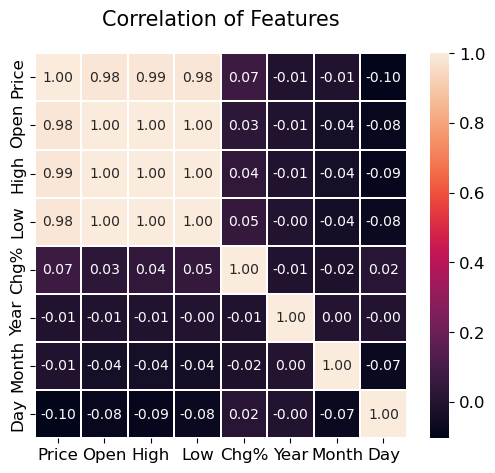

In [10]:
corr = goldprice.corr()
plt.figure(figsize = (6,5))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,fmt='.2f',linewidths=0.30)
plt.title('Correlation of Features', y = 1.05, size=15)

In [11]:
goldprice.dtypes

Date     datetime64[ns]
Price           float64
Open            float64
High            float64
Low             float64
Chg%            float64
Year              int64
Month             int64
Day               int64
dtype: object

In [12]:
df = pd.DataFrame(goldprice, columns = ['Date', 'Price'])
df.head()

,Date,Price
0,2020-09-11,1957.35
1,2020-09-10,1964.30
2,2020-09-09,1954.90
3,2020-09-08,1943.20
4,2020-09-07,1937.10


In [13]:
from IPython.display import display
display(df[:10].T)

,0,1,2,3,4,5,6,7,8,9
Date,2020-09-11 00:00:00,2020-09-10 00:00:00,2020-09-09 00:00:00,2020-09-08 00:00:00,2020-09-07 00:00:00,2020-09-06 00:00:00,2020-09-04 00:00:00,2020-09-03 00:00:00,2020-09-02 00:00:00,2020-09-01 00:00:00
Price,1957.35,1964.3,1954.9,1943.2,1937.1,1940.65,1934.3,1937.8,1944.7,1978.9


In [14]:
df.head()

,Date,Price
0,2020-09-11,1957.35
1,2020-09-10,1964.30
2,2020-09-09,1954.90
3,2020-09-08,1943.20
4,2020-09-07,1937.10


In [15]:
y = df.set_index('Date')

In [16]:
y.index

DatetimeIndex(['2020-09-11', '2020-09-10', '2020-09-09', '2020-09-08',
               '2020-09-07', '2020-09-06', '2020-09-04', '2020-09-03',
               '2020-09-02', '2020-09-01',
               ...
               '2011-01-14', '2011-01-13', '2011-01-12', '2011-01-11',
               '2011-01-10', '2011-01-07', '2011-01-06', '2011-01-05',
               '2011-01-04', '2011-01-03'],
              dtype='datetime64[ns]', name='Date', length=2531, freq=None)

## Exploratory Data Analysis 

### Explore price development

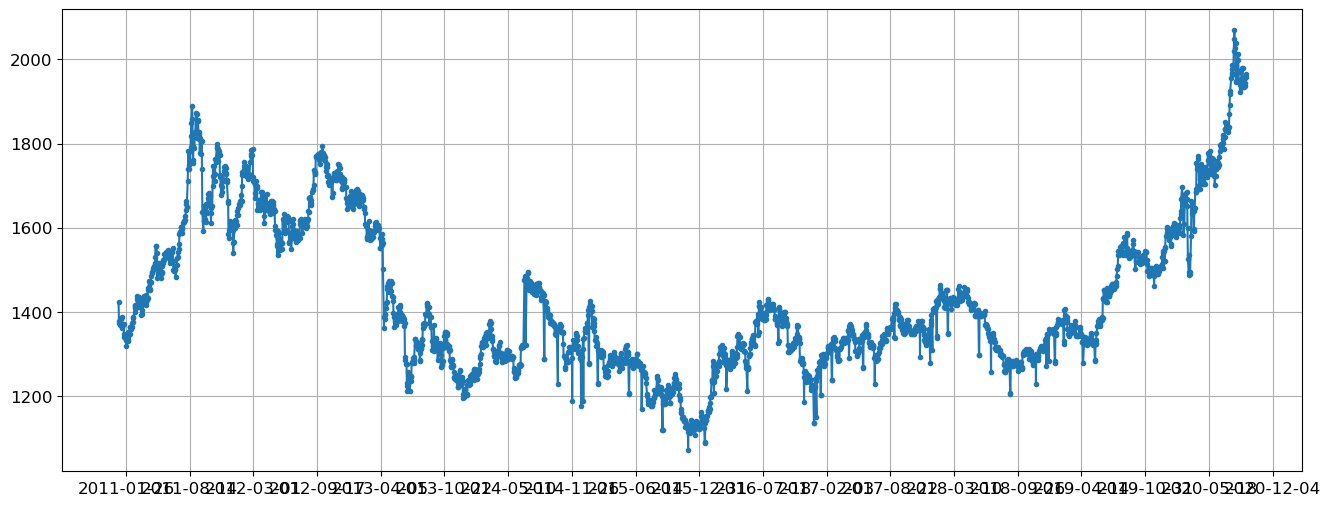

In [17]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(df.Date, df.Price, marker='.')
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) # reduce number of x-labels
plt.grid()
plt.show()

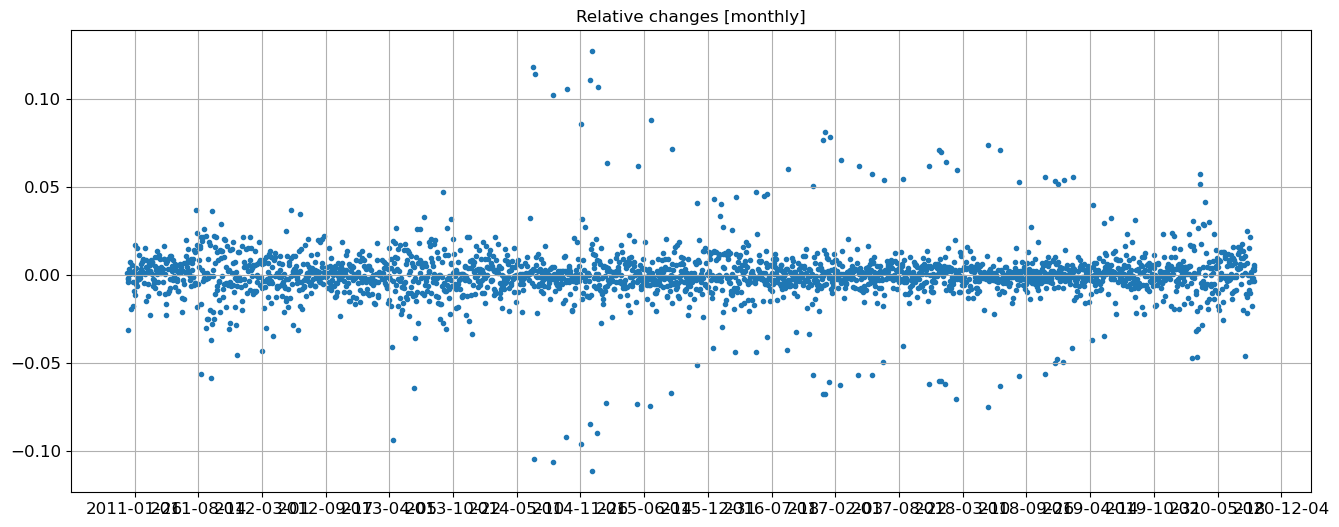

In [18]:
fig, ax = plt.subplots(figsize=(16,6))
ax.scatter(df['Date'], goldprice['Chg%'], marker='.')
ax.xaxis.set_major_locator(plt.MaxNLocator(20)) # reduce number of x-labels
plt.title('Relative changes [monthly]')
plt.grid()
plt.show()

### Relative changes distribution

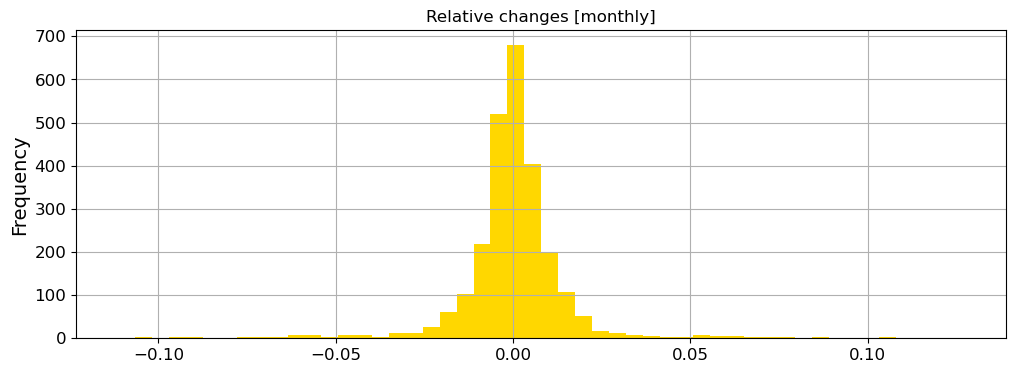

In [19]:
plt.figure(figsize=(12,4))
goldprice['Chg%'].plot(kind='hist', bins=50, color='gold')
plt.title('Relative changes [monthly]')
plt.grid()
plt.show()

In [20]:
y.isnull().sum()

Price    0
dtype: int64

In [21]:
stationary_check_gold = df.set_index(['Date'])

stationary_check_gold_price = stationary_check_gold['Price']

### Non-Stationary time series of Gold

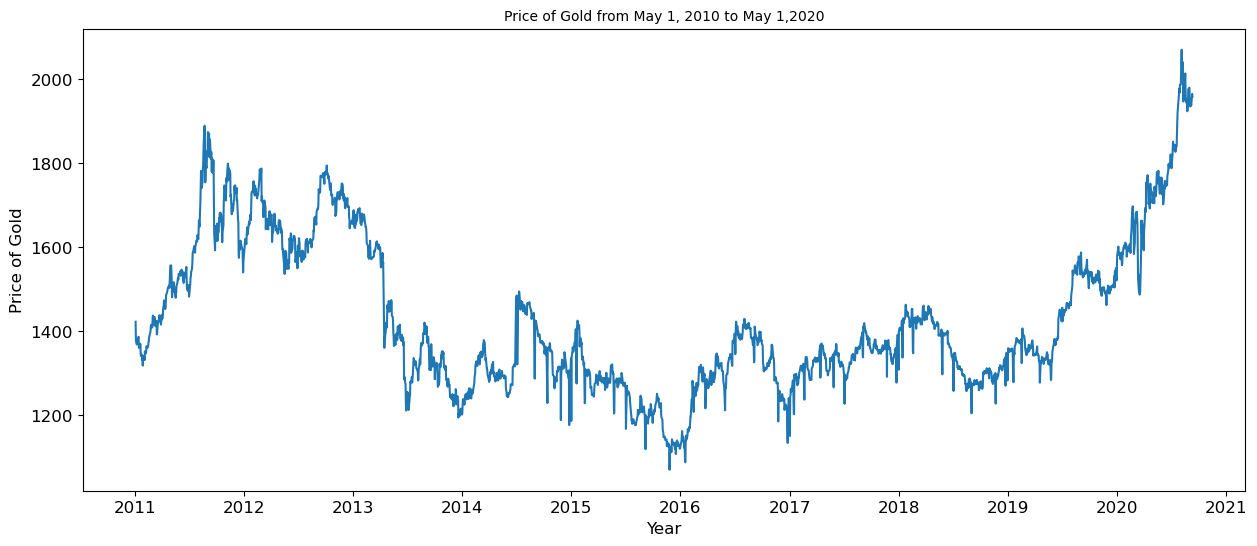

In [22]:
plt.plot(stationary_check_gold_price)
plt.ylabel('Price of Gold', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.title('Price of Gold from May 1, 2010 to May 1,2020', fontsize=10)
plt.show()

#### Inference

- The distribution is not perfectly Gaussian (normal distribution).  

- The distribution is left shifted.  

- Transformations might be useful prior to modelling.    


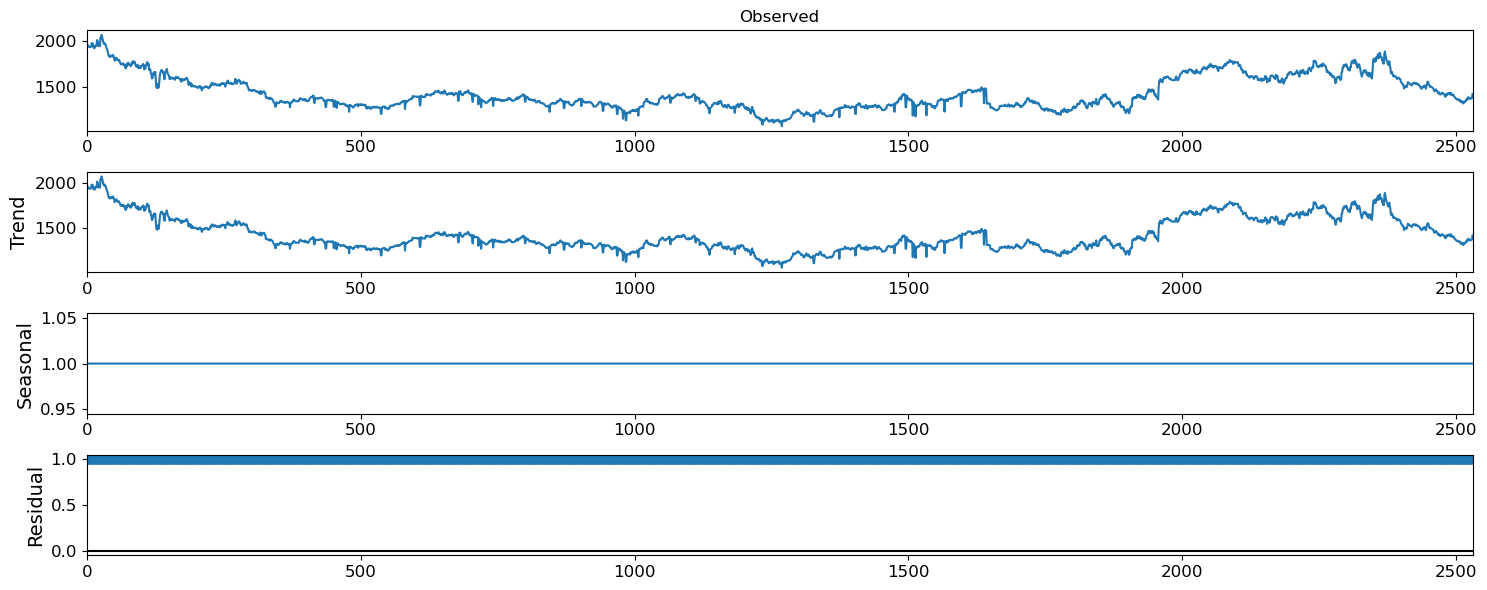

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

# multiplicative
res = seasonal_decompose(stationary_check_gold_price.values, model='multiplicative', period=1)
fig = res.plot()

### Box and Whisker Plots:

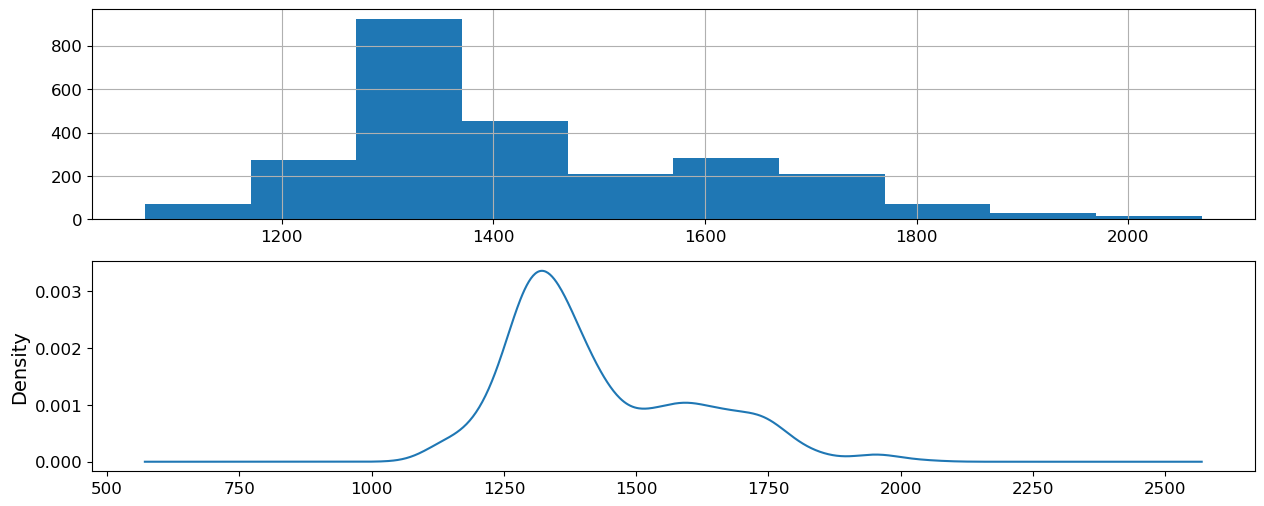

In [24]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
stationary_check_gold_price.hist()
pyplot.subplot(212)
stationary_check_gold_price.plot(kind='kde')
pyplot.show()

<AxesSubplot:xlabel='Date', ylabel='Price'>

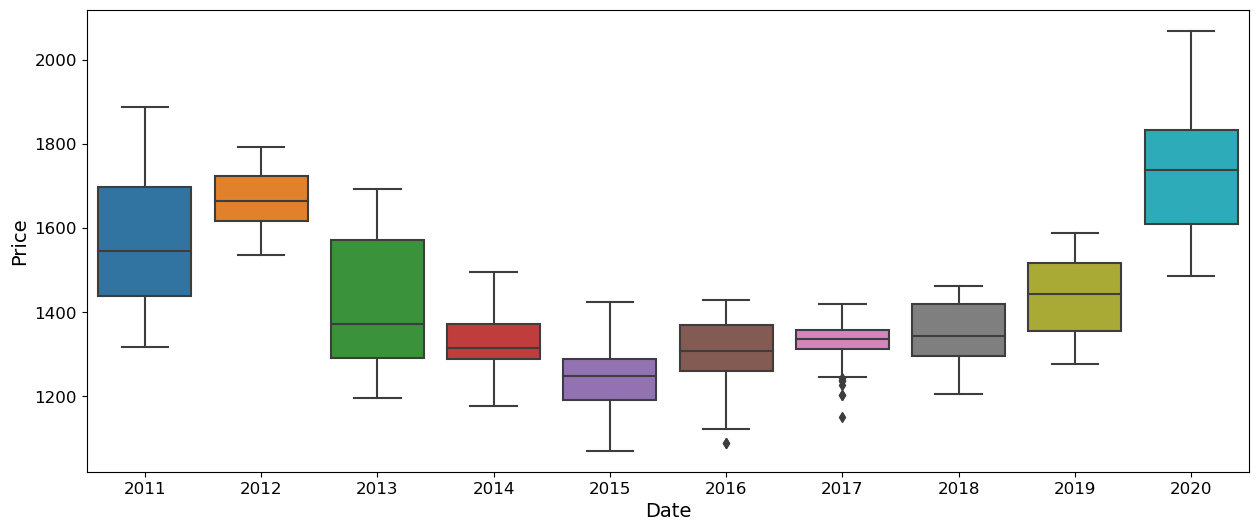

In [25]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(stationary_check_gold_price.index.year, stationary_check_gold_price, ax=ax)

### Plotting the Stationarity

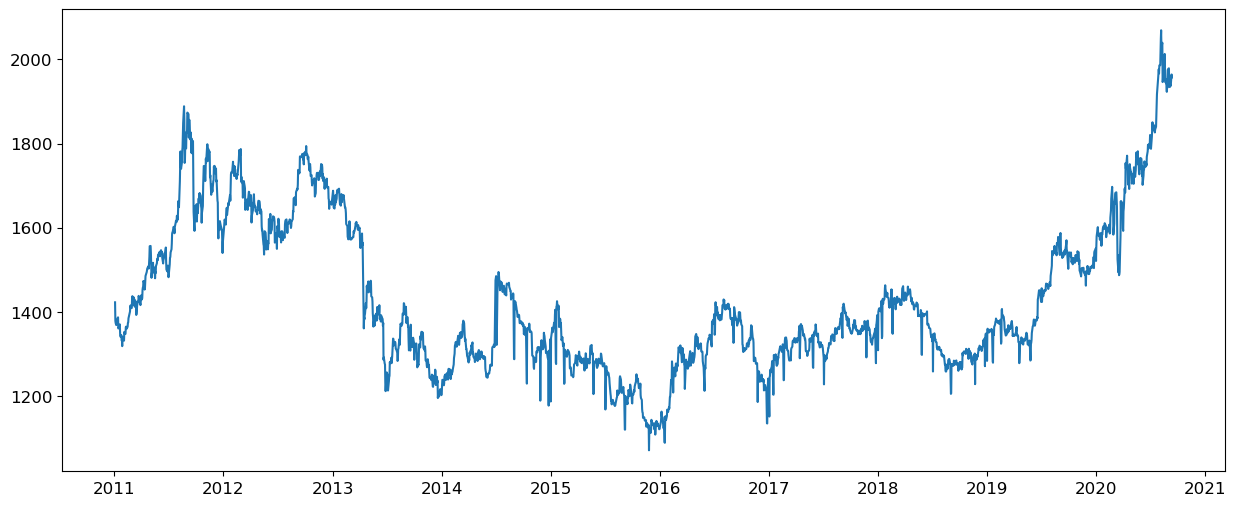

In [26]:
plt.plot(stationary_check_gold_price)

### Analysing the Stationarity using Autocorrelation and Partial Autocorrelation functions

###  Autocorrelations

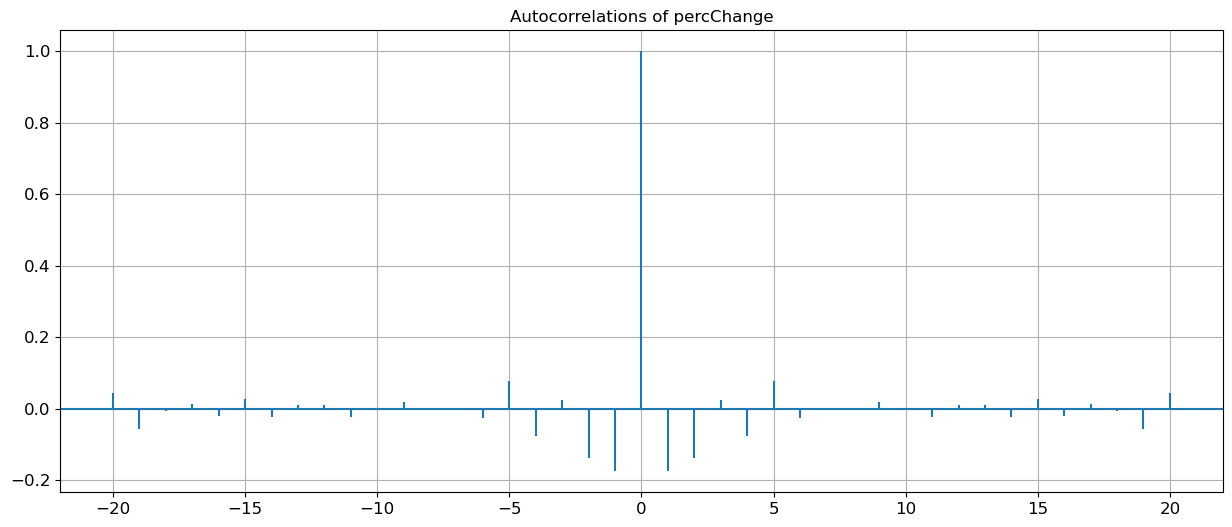

In [27]:
plt.acorr(goldprice['Chg%'], maxlags=20)
plt.title('Autocorrelations of percChange')
plt.grid()
plt.show()

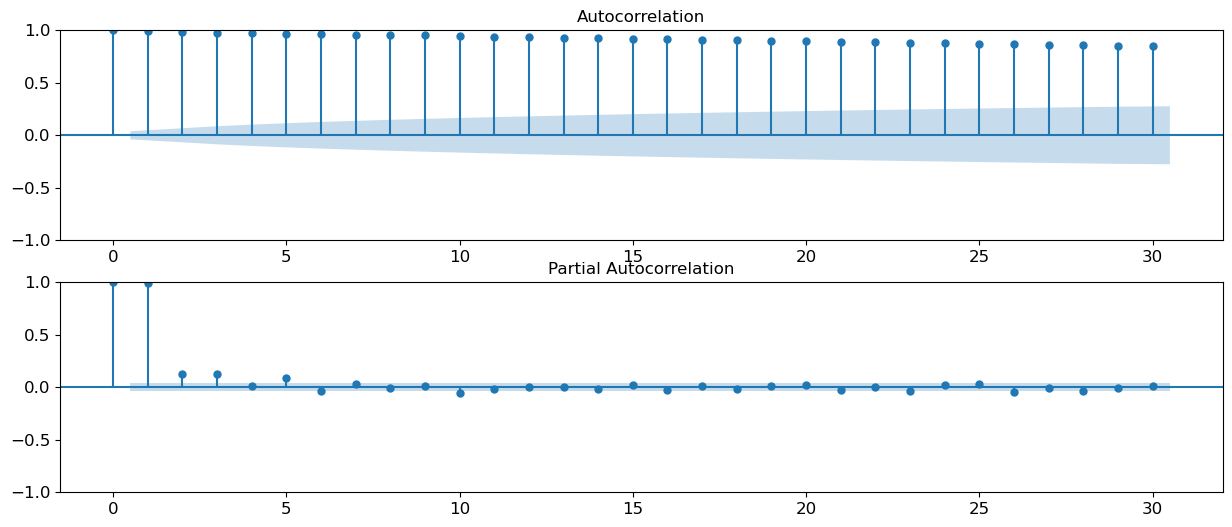

In [28]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(stationary_check_gold_price, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(stationary_check_gold_price, ax=pyplot.gca(), lags = 30)
pyplot.show()

### Plotting Rolling Statistics

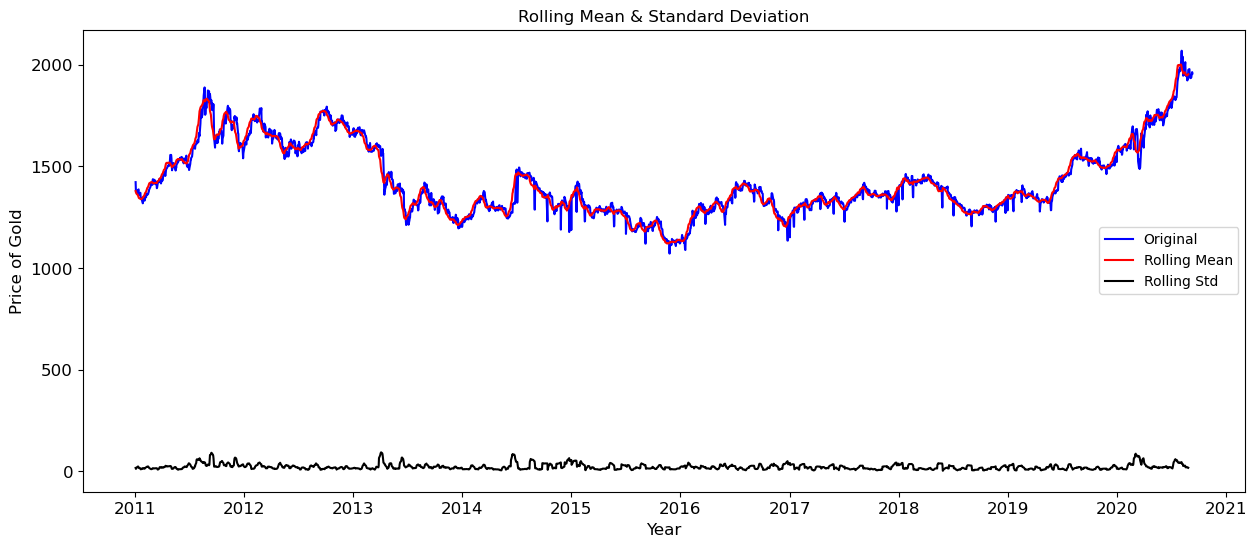

Results of Dickey-Fuller Test:
Test Statistic                   -3.030208
p-value                           0.032168
#Lags Used                        6.000000
Number of Observations Used    2524.000000
Critical Value (1%)              -3.432943
Critical Value (5%)              -2.862686
Critical Value (10%)             -2.567380
dtype: float64


In [29]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.ylabel('Price of Gold', fontsize=12)
    plt.xlabel('Year', fontsize=12)
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print( 'Results of Dickey-Fuller Test:' )
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(stationary_check_gold_price)

### Perfroming Augmented Dickey-Fuller Test

In [30]:
from statsmodels.tsa.stattools import adfuller

In [31]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(stationary_check_gold_price, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -3.030208
p-value                           0.032168
#Lags Used                        6.000000
Number of Observations Used    2524.000000
Critical Value (1%)              -3.432943
Critical Value (5%)              -2.862686
Critical Value (10%)             -2.567380
dtype: float64


In [32]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

### Making Time Series Stationary using Log Scale Transformation

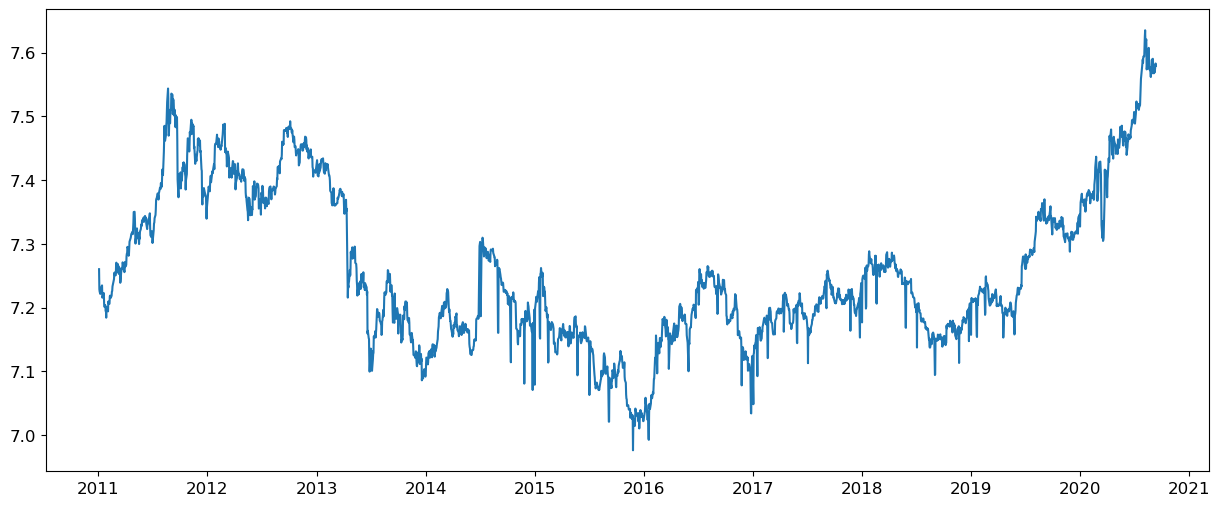

In [33]:
ts_log = np.log(stationary_check_gold_price)
plt.plot(ts_log)

### Using multiple techniques to remove Trend - Smoothing

#### Moving Average

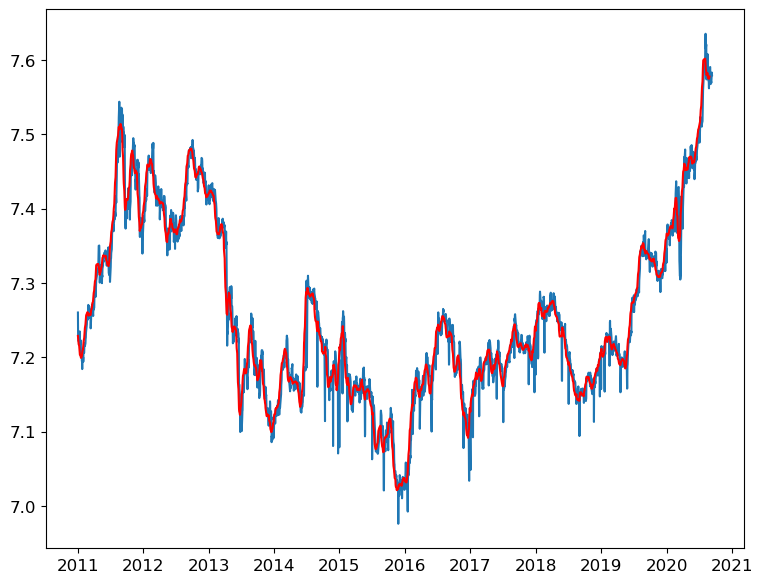

In [34]:
moving_avg = ts_log.rolling(window=12,center=False).mean()  # taking average of LAST 2 years (36-12) values
plt.figure(figsize=(9,7))
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
plt.show()

In [35]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12) 

Date
2020-09-11         NaN
2020-09-10         NaN
2020-09-09         NaN
2020-09-08         NaN
2020-09-07         NaN
2020-09-06         NaN
2020-09-04         NaN
2020-09-03         NaN
2020-09-02         NaN
2020-09-01         NaN
2020-08-31         NaN
2020-08-28    0.010728
Name: Price, dtype: float64

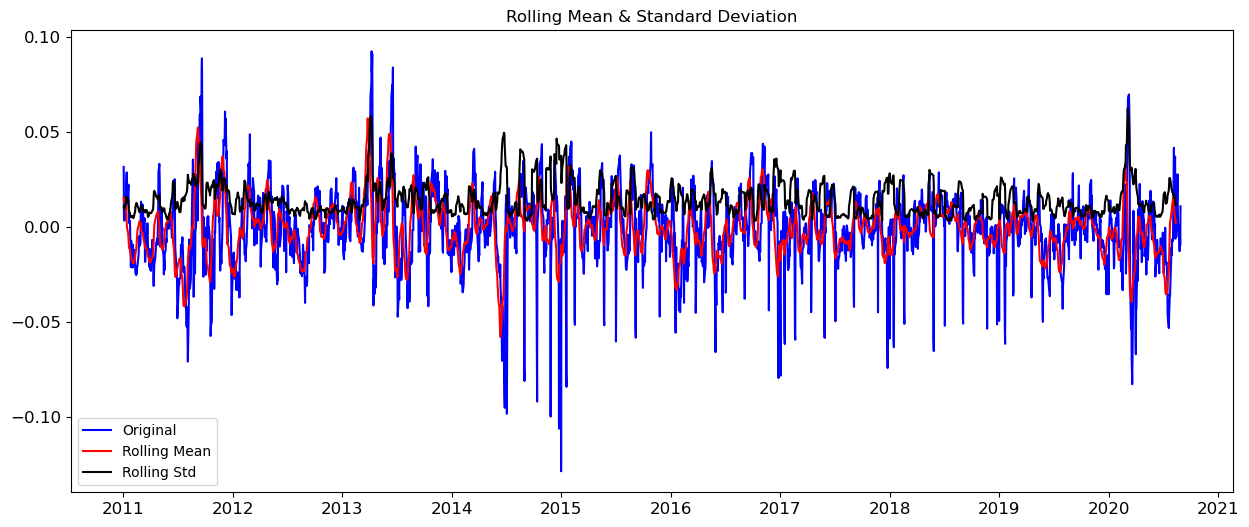

Results of Dickey-Fuller Test:
Test Statistic                -1.194664e+01
p-value                        4.414553e-22
#Lags Used                     1.100000e+01
Number of Observations Used    2.508000e+03
Critical Value (1%)           -3.432960e+00
Critical Value (5%)           -2.862693e+00
Critical Value (10%)          -2.567384e+00
dtype: float64


In [36]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

#### Weighted Moving Average

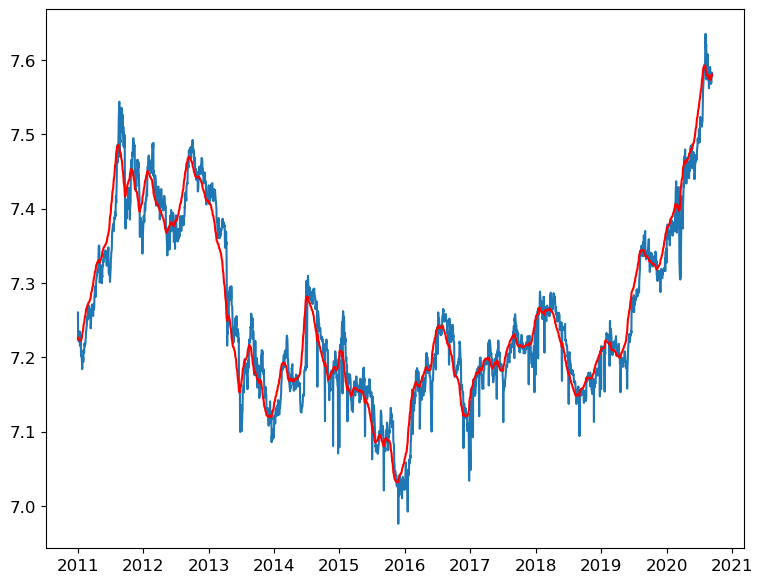

In [37]:
expwighted_avg = ts_log.ewm(halflife=12,ignore_na=False,min_periods=0,adjust=True).mean()
plt.figure(figsize=(9,7))
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')
plt.show()

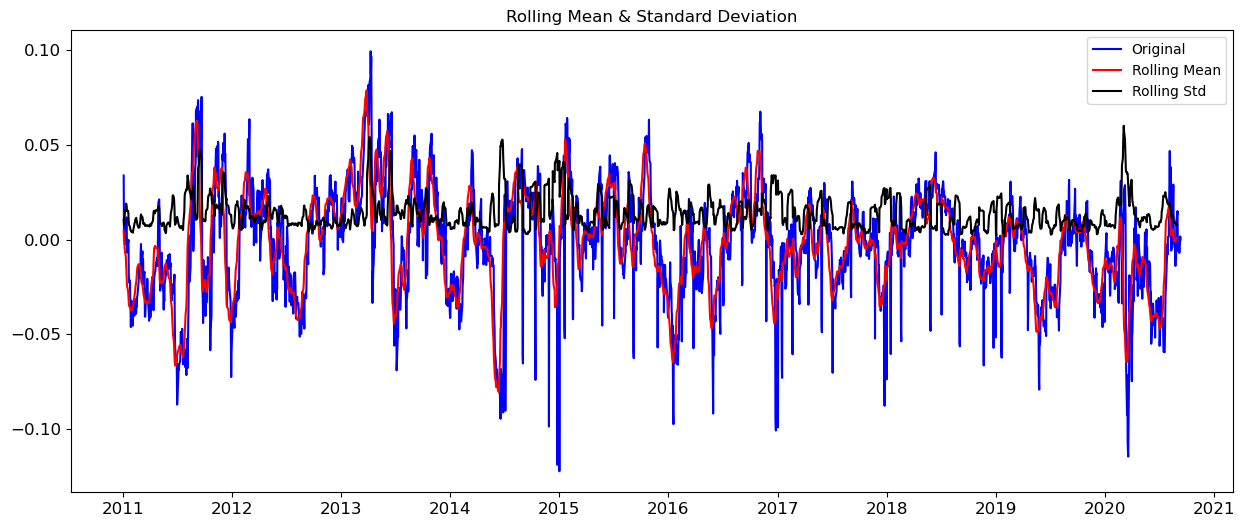

Results of Dickey-Fuller Test:
Test Statistic                -8.294622e+00
p-value                        4.172288e-13
#Lags Used                     6.000000e+00
Number of Observations Used    2.524000e+03
Critical Value (1%)           -3.432943e+00
Critical Value (5%)           -2.862686e+00
Critical Value (10%)          -2.567380e+00
dtype: float64


In [38]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

### Splitting the data

In [39]:
X = goldprice.drop(['Date','Price'],axis=1)

In [40]:
X

,Open,High,Low,Chg%,Year,Month,Day
0,1952.55,1963.3,1944.35,-0.0035,11,9,2020
1,1955.30,1975.2,1948.60,0.0048,10,9,2020
2,1939.40,1959.7,1926.30,0.0060,9,9,2020
3,1938.00,1948.3,1911.70,0.0031,8,9,2020
4,1940.70,1947.4,1930.45,-0.0018,7,9,2020
...,...,...,...,...,...,...,...
2526,1372.70,1377.2,1355.50,-0.0021,7,1,2011
2527,1374.80,1376.5,1368.90,-0.0015,6,1,2011
2528,1383.40,1384.0,1364.20,-0.0037,5,1,2011
2529,1409.60,1410.9,1375.80,-0.0310,4,1,2011


In [41]:
X.shape

(2531, 7)

In [42]:
y = goldprice['Price']

In [43]:
y

0       1957.35
1       1964.30
2       1954.90
3       1943.20
4       1937.10
         ...   
2526    1368.50
2527    1371.40
2528    1373.40
2529    1378.50
2530    1422.60
Name: Price, Length: 2531, dtype: float64

In [44]:
y.shape

(2531,)

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=2)

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

## Using Random Forest Regressor

In [48]:
def predict(algorithm):
    model = algorithm.fit(X_train,y_train)
    print('Training Score: {}'.format(model.score(X_train,y_train)))

    preds = model.predict(X_test)
    print('Predictions are: {}'.format(preds))
    print('\n')

    r2_score = metrics.r2_score(y_test,preds)
    print('r2_score is:{}'.format(r2_score))

    print('MAE:',metrics.mean_absolute_error(y_test,preds))
    print('MSE:',metrics.mean_squared_error(y_test,preds))
    print('RMSE:',np.sqrt(metrics.mean_squared_error(y_test,preds)))
    sns.distplot(y_test-preds,color='green')

Training Score: 0.9995548533793888
Predictions are: [1280.289  1373.92   1342.3228 1717.309  1331.0745 1290.692  1143.731
 1345.391  1265.7638 1304.532  1712.888  1344.6608 1361.011  1282.6
 1572.176  1313.768  1333.0295 1405.762  1524.6215 1331.179  1755.966
 1341.267  1416.045  1266.386  1328.4355 1537.716  1749.419  1202.021
 1592.3245 1966.582  1355.628  1333.029  1679.163  1402.077  1321.8725
 1361.368  1588.93   1394.865  1650.124  1368.305  1195.539  1361.772
 1427.366  1243.191  1313.642  1284.923  1627.745  1367.51   1444.041
 1335.2685 1279.553  1595.463  1356.732  1542.691  1445.032  1303.648
 1272.221  1535.2545 1265.4298 1522.5805 1372.302  1754.236  1753.198
 1584.582  1347.692  1639.725  1248.2355 1676.187  1551.936  1499.04
 1626.034  1453.76   1586.698  1678.585  1571.747  1561.6125 1234.113
 1233.388  1323.738  1258.784  1358.098  1495.3945 1349.688  1342.705
 1568.503  1595.192  1296.1702 1445.292  1603.107  1575.5845 1275.446
 1323.139  1411.431  1433.96   1602.3375

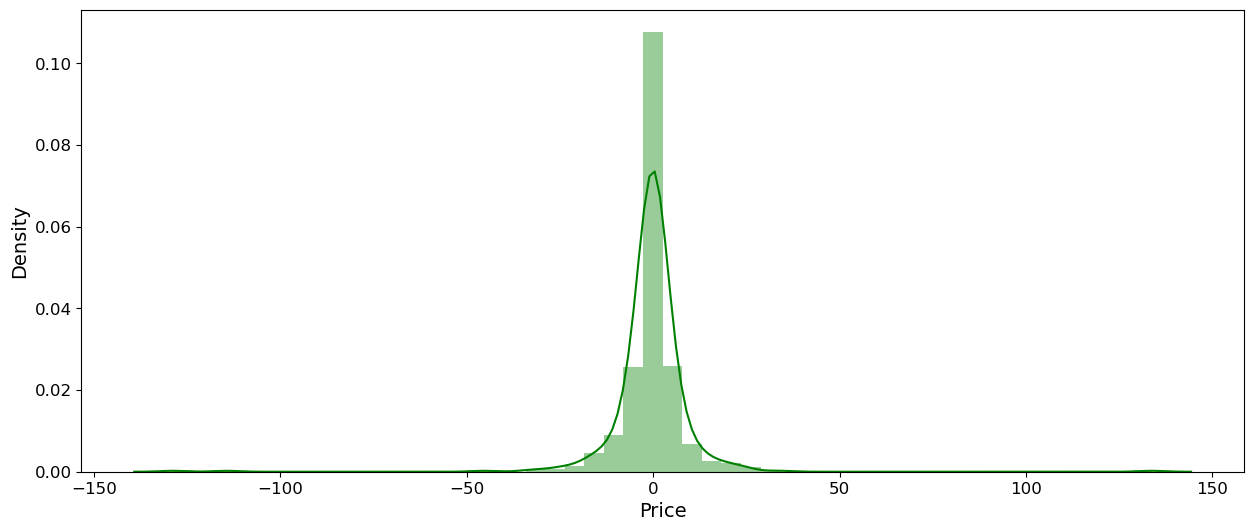

In [49]:
from sklearn.ensemble import RandomForestRegressor

predict(RandomForestRegressor())

## Using Linear Regression

Training Score: 0.9720489762983339
Predictions are: [1287.46509401 1381.1335197  1349.02699003 1708.15351128 1337.6139623
 1305.2974777  1176.84026124 1348.79406241 1274.67616002 1316.54671617
 1722.3847627  1348.61530229 1370.70980134 1292.16250098 1569.34503439
 1316.63295296 1335.3827299  1411.79896563 1527.80814535 1330.94094103
 1739.072931   1341.43834851 1422.95738006 1270.20100171 1332.58185012
 1548.35263609 1740.92377919 1218.09105188 1585.98911985 1952.22431769
 1376.77944912 1345.10439649 1675.54758129 1278.10874728 1324.17910345
 1363.29713204 1602.85035255 1396.97035239 1646.77730068 1375.16890577
 1217.21910521 1392.55717245 1419.43210369 1265.89287443 1335.27249572
 1288.03513898 1624.16678634 1369.81739241 1439.40405146 1337.01326427
 1301.14760161 1597.38675689 1369.60254536 1544.02617924 1442.70147853
 1309.45200532 1285.29685425 1540.80458533 1272.27537545 1541.33150534
 1390.21604477 1749.5876601  1750.43403024 1610.78462962 1356.7009396
 1658.18878433 1275.8347959

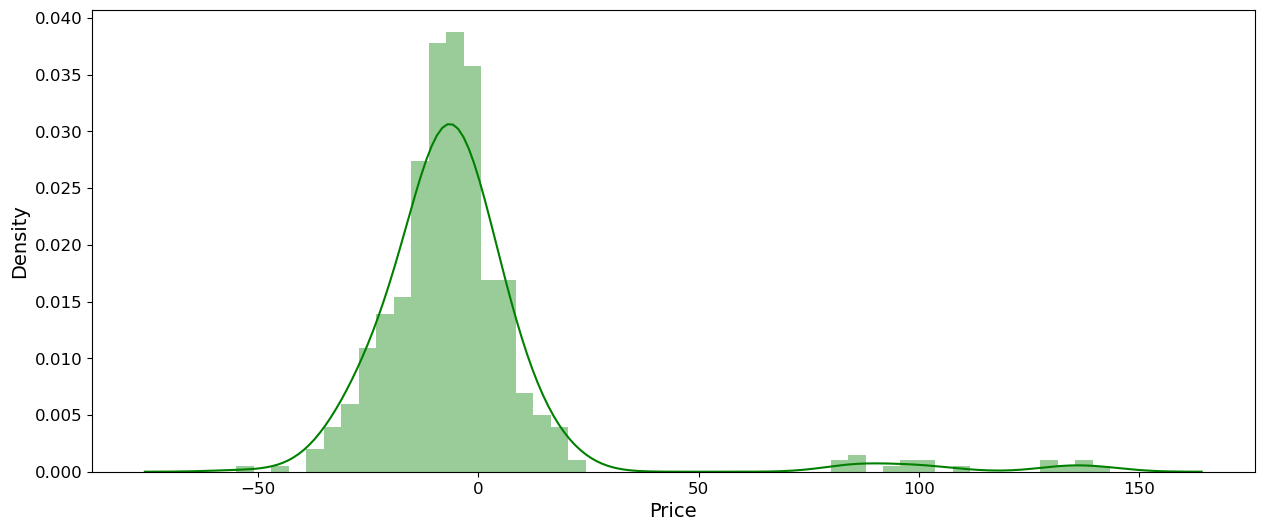

In [50]:
from sklearn.linear_model import LinearRegression

predict(LinearRegression())

## Using KNNs

Training Score: 0.9837444890953134
Predictions are: [1279.48 1374.9  1404.26 1724.9  1328.86 1323.04 1168.06 1345.26 1265.88
 1305.78 1714.38 1342.8  1361.6  1282.3  1570.3  1313.98 1333.76 1409.06
 1525.58 1391.14 1746.76 1335.34 1418.38 1263.28 1328.9  1535.54 1756.98
 1246.56 1592.02 1968.   1356.22 1330.64 1684.4  1319.74 1322.74 1362.52
 1587.44 1394.04 1650.4  1370.28 1221.7  1368.46 1424.7  1243.72 1346.72
 1287.26 1628.64 1367.04 1441.18 1334.74 1277.46 1600.12 1355.3  1540.3
 1445.76 1303.64 1272.5  1536.56 1265.18 1528.82 1372.6  1753.12 1757.42
 1595.9  1347.3  1630.96 1249.8  1670.56 1552.92 1494.9  1613.12 1454.44
 1590.62 1674.54 1566.66 1561.   1255.75 1259.1  1320.39 1255.08 1358.76
 1490.02 1347.24 1296.   1563.72 1591.84 1326.8  1443.58 1599.68 1575.54
 1330.8  1325.96 1413.24 1431.56 1607.38 1537.47 1788.48 1291.58 1308.74
 1272.38 1779.96 1252.67 1417.5  1222.62 1366.28 1289.78 1459.58 1495.3
 1576.26 1413.76 1736.14 1428.78 1387.48 1946.28 1678.92 1651.72 1305.
 12

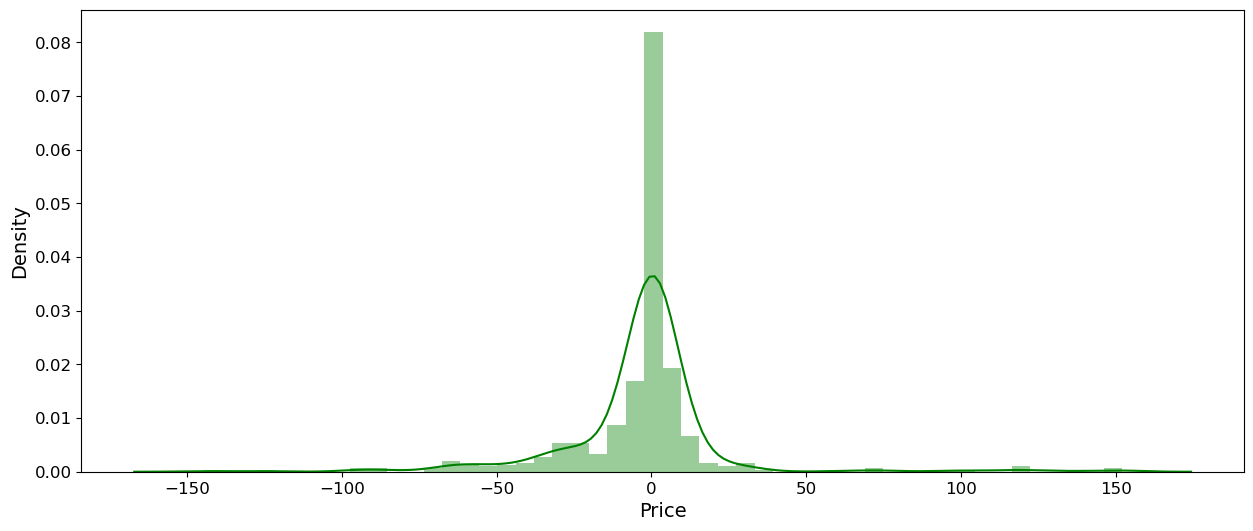

In [51]:
from sklearn.neighbors import KNeighborsRegressor

predict(KNeighborsRegressor())

## Using Decision Tree

Training Score: 1.0
Predictions are: [1280.2  1374.5  1340.2  1717.5  1328.5  1293.8  1141.3  1345.5  1265.8
 1303.5  1708.8  1343.5  1363.8  1282.1  1564.   1313.7  1333.7  1408.
 1523.   1328.5  1754.4  1335.8  1416.2  1267.6  1328.5  1536.3  1750.4
 1203.5  1592.4  1946.3  1348.3  1328.5  1684.1  1439.   1322.5  1364.
 1591.6  1394.8  1652.2  1368.1  1195.2  1373.6  1433.1  1242.2  1314.4
 1285.5  1625.7  1366.8  1434.8  1335.8  1276.4  1599.   1361.6  1545.
 1447.9  1297.6  1272.4  1538.1  1264.9  1515.   1371.2  1764.2  1768.6
 1598.8  1346.3  1638.9  1252.1  1683.4  1551.8  1499.1  1641.9  1454.9
 1578.2  1683.3  1574.5  1561.9  1225.3  1221.7  1325.9  1260.4  1358.1
 1491.   1361.6  1366.6  1563.1  1589.   1298.1  1446.3  1615.2  1562.9
 1257.9  1324.2  1410.7  1426.2  1663.   1539.6  1794.1  1361.3  1293.3
 1260.8  1787.   1257.9  1416.2  1197.7  1367.3  1287.8  1452.3  1493.2
 1574.8  1414.   1730.6  1428.1  1386.8  1943.2  1670.4  1655.   1306.4
 1291.9  1740.   1433.1  1323.

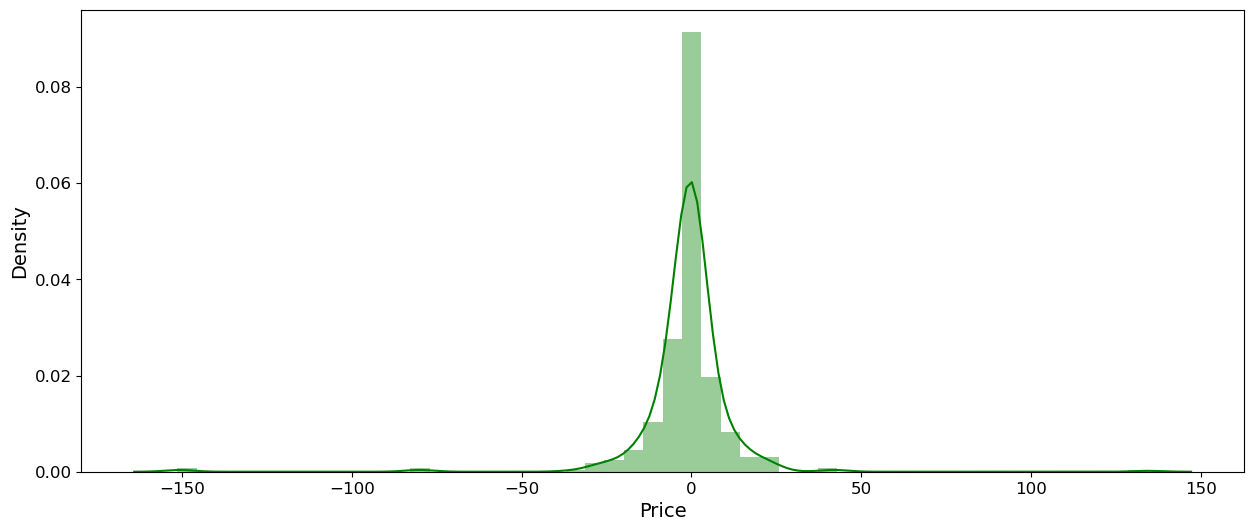

In [52]:
from sklearn.tree import DecisionTreeRegressor 

predict(DecisionTreeRegressor())

### Using XGBoost

Training Score: 0.9999150151063957
Predictions are: [1279.3741 1373.7363 1346.5231 1715.803  1339.0215 1298.5521 1143.7229
 1346.6615 1267.2095 1305.2317 1713.5254 1344.515  1363.8265 1282.4237
 1583.0828 1311.5073 1331.473  1407.7346 1528.774  1326.2625 1757.4226
 1335.5555 1418.92   1262.235  1327.4017 1545.5519 1749.7029 1198.0544
 1590.9882 1955.0437 1371.4983 1335.2383 1665.7634 1358.4923 1321.1927
 1365.8217 1590.1044 1391.4438 1651.0529 1368.3861 1200.0408 1371.1096
 1424.4255 1243.9009 1309.4283 1285.1232 1632.0411 1367.4998 1446.8153
 1333.1531 1279.2205 1592.2975 1356.6539 1546.146  1445.6083 1304.9673
 1275.4812 1535.1455 1264.4347 1525.4209 1382.2441 1756.9905 1748.8563
 1567.2    1346.9513 1647.0315 1252.3938 1673.8618 1548.7074 1484.8496
 1614.7352 1454.9053 1571.4489 1673.5258 1563.1678 1564.1687 1235.2512
 1235.4125 1328.1295 1255.0367 1355.6382 1478.7971 1354.9398 1355.8126
 1576.9004 1598.194  1299.2172 1447.8309 1603.8348 1566.9557 1275.9071
 1325.3003 1411.9722 1429

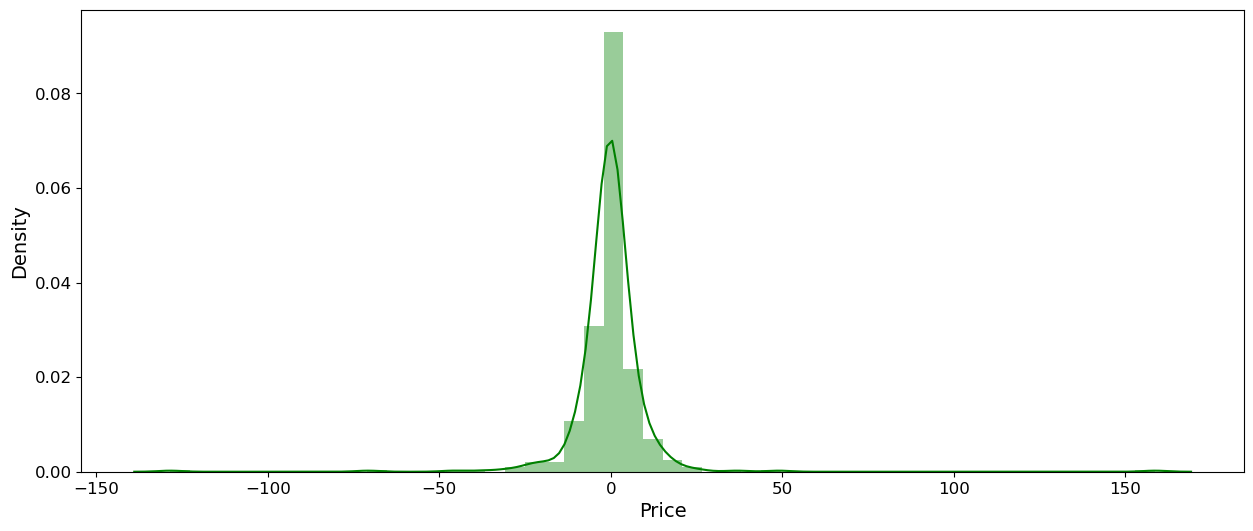

In [53]:
from xgboost import XGBRegressor

predict(XGBRegressor())

## Building the ARIMA model

In [54]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(stationary_check_gold_price, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packa

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                 2531
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -11341.408
Date:                Sat, 25 Nov 2023   AIC                          22694.815
Time:                        14:07:41   BIC                          22729.831
Sample:                             0   HQIC                         22707.520
                               - 2531                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1807      0.010    -17.657      0.000      -0.201      -0.161
ar.L2         -0.1713      0.012    -13.747      0.000      -0.196      -0.147
ar.L3         -0.0402      0.022     -1.789      0.0

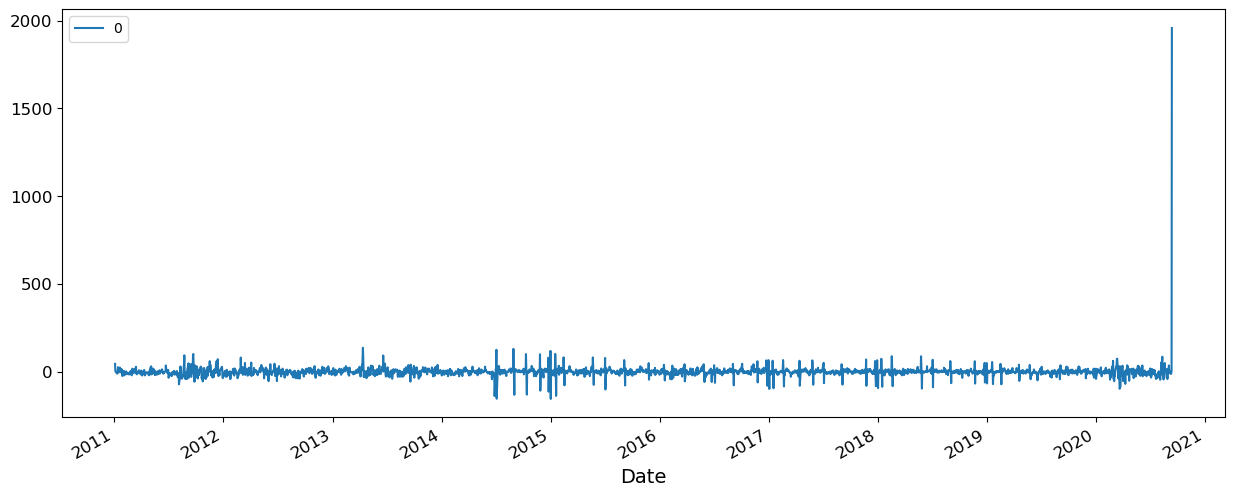

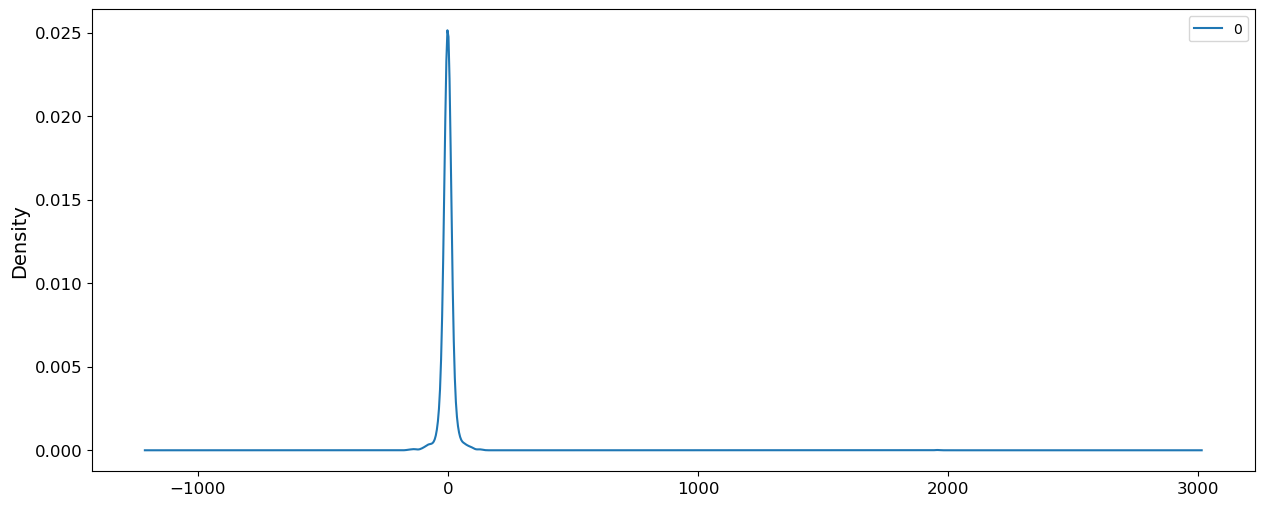

                 0
count  2531.000000
mean      0.455939
std      44.412299
min    -154.536356
25%      -8.246394
50%      -0.037432
75%       7.817965
max    1957.350000


In [55]:
from pandas import DataFrame
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [56]:
# from pandas import DataFrame

# # fit model
# model = ARIMA(stationary_check_gold_price, order=(5,1,0))
# model_fit = model.fit(disp=0)  
# print(model_fit.summary())

# # plot residual errors
# residuals = DataFrame(model_fit.resid)
# residuals.plot()
# pyplot.show()
# residuals.plot(kind='kde')
# pyplot.show()
# print(residuals.describe())

predicted=1212.490496, expected=1201.900000
predicted=1208.876591, expected=1203.100000
predicted=1207.223054, expected=1216.100000
predicted=1215.352889, expected=1214.100000
predicted=1211.395030, expected=1205.100000
predicted=1206.496677, expected=1198.400000
predicted=1200.701240, expected=1205.100000
predicted=1206.384924, expected=1195.000000
predicted=1197.636004, expected=1236.100000
predicted=1228.556400, expected=1231.200000
predicted=1221.990987, expected=1245.500000
predicted=1241.119519, expected=1235.700000
predicted=1229.127670, expected=1226.000000
predicted=1230.999537, expected=1258.500000
predicted=1251.559875, expected=1262.400000
predicted=1255.801622, expected=1235.300000
predicted=1239.465422, expected=1230.300000
predicted=1233.284087, expected=1233.200000
predicted=1236.111901, expected=1248.200000
predicted=1248.001866, expected=1221.700000
predicted=1224.512974, expected=1222.300000
predicted=1226.976682, expected=1250.600000
predicted=1243.646926, expected=

predicted=1473.887693, expected=1564.300000
predicted=1518.598550, expected=1558.300000
predicted=1539.817502, expected=1586.200000
predicted=1559.620943, expected=1572.000000
predicted=1565.563561, expected=1575.400000
predicted=1578.716341, expected=1551.800000
predicted=1553.593257, expected=1552.800000
predicted=1559.952823, expected=1575.100000
predicted=1570.447956, expected=1600.000000
predicted=1592.524073, expected=1594.800000
predicted=1588.537544, expected=1606.200000
predicted=1600.709559, expected=1595.800000
predicted=1593.511944, expected=1604.600000
predicted=1605.534382, expected=1606.200000
predicted=1603.017392, expected=1613.800000
predicted=1612.824090, expected=1607.500000
predicted=1605.831416, expected=1611.300000
predicted=1611.423085, expected=1604.600000
predicted=1604.753555, expected=1592.500000
predicted=1597.381831, expected=1590.600000
predicted=1593.389443, expected=1588.300000
predicted=1590.816411, expected=1591.500000
predicted=1592.676658, expected=

predicted=1587.791561, expected=1591.600000
predicted=1591.112353, expected=1564.900000
predicted=1568.083200, expected=1575.200000
predicted=1578.811115, expected=1579.300000
predicted=1577.715000, expected=1588.600000
predicted=1588.213585, expected=1578.400000
predicted=1576.520500, expected=1608.900000
predicted=1603.721894, expected=1621.300000
predicted=1611.877698, expected=1597.200000
predicted=1599.607033, expected=1603.500000
predicted=1602.763876, expected=1549.700000
predicted=1560.819054, expected=1577.500000
predicted=1585.394673, expected=1574.000000
predicted=1570.547992, expected=1587.500000
predicted=1590.042202, expected=1566.000000
predicted=1563.469612, expected=1564.500000
predicted=1569.686206, expected=1614.800000
predicted=1603.676304, expected=1622.200000
predicted=1613.034943, expected=1625.700000
predicted=1620.143103, expected=1627.000000
predicted=1619.866037, expected=1618.400000
predicted=1620.436465, expected=1618.100000
predicted=1619.692925, expected=

predicted=1671.668507, expected=1667.300000
predicted=1668.216063, expected=1681.300000
predicted=1678.423393, expected=1659.700000
predicted=1662.282911, expected=1669.600000
predicted=1672.503535, expected=1634.500000
predicted=1639.043442, expected=1651.900000
predicted=1656.851647, expected=1640.300000
predicted=1639.710821, expected=1614.700000
predicted=1625.057450, expected=1656.000000
predicted=1649.953291, expected=1620.400000
predicted=1623.294200, expected=1615.500000
predicted=1623.195866, expected=1616.300000
predicted=1613.680874, expected=1650.600000
predicted=1648.640433, expected=1592.500000
predicted=1597.806606, expected=1637.500000
predicted=1636.557389, expected=1739.200000
predicted=1709.479200, expected=1805.500000
predicted=1778.897222, expected=1806.600000
predicted=1783.568970, expected=1776.400000
predicted=1769.583282, expected=1812.100000
predicted=1807.109296, expected=1778.500000
predicted=1781.975752, expected=1823.500000
predicted=1821.821460, expected=

predicted=1364.895267, expected=1360.400000
predicted=1360.553289, expected=1386.900000
predicted=1381.362967, expected=1385.700000
predicted=1382.582767, expected=1384.000000
predicted=1384.140142, expected=1373.700000
predicted=1373.102313, expected=1368.500000
predicted=1372.169763, expected=1371.400000
predicted=1372.310958, expected=1373.400000
predicted=1373.702226, expected=1378.500000
predicted=1377.321698, expected=1422.600000
Test MSE: 417.137


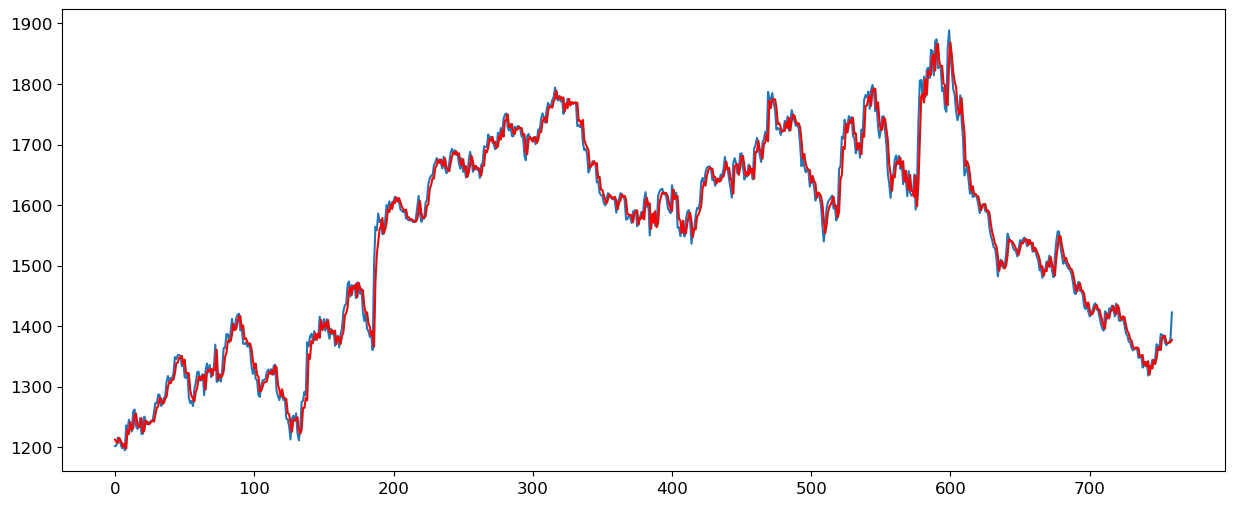

In [57]:
from sklearn.metrics import mean_squared_error

X = stationary_check_gold_price.values
size = int(len(X) * 0.7)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    y_pred = output[0]
    predictions.append(y_pred)
    obs = test[t]
    history.append(obs)  # The observation value in the last run will be put as the history for the next run
    print('predicted=%f, expected=%f' % (y_pred, obs))  # compare each prediction and observation
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot the forecast
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### Using this ARIMA model on differenciated outputs

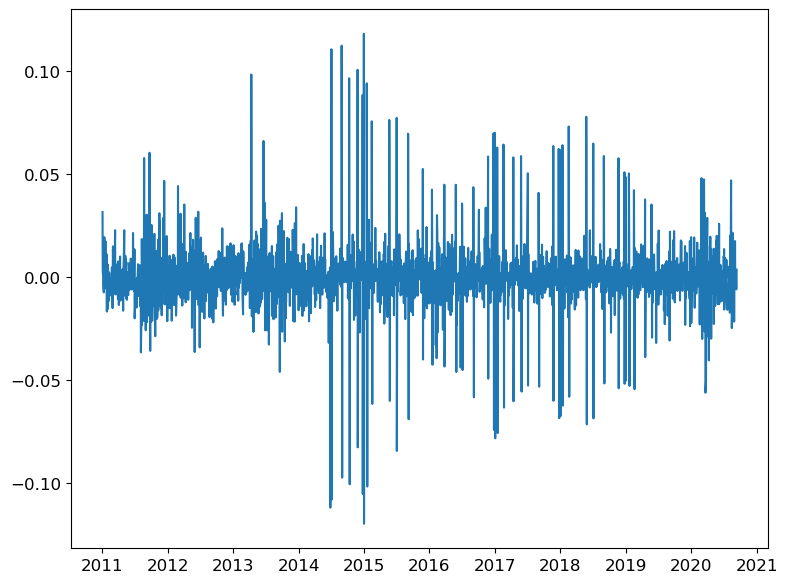

In [58]:
ts_log_diff = ts_log - ts_log.shift()
plt.figure(figsize=(9,7))
plt.plot(ts_log_diff)
plt.show()

In [59]:
ts_log_diff.head()

Date
2020-09-11         NaN
2020-09-10    0.003544
2020-09-09   -0.004797
2020-09-08   -0.006003
2020-09-07   -0.003144
Name: Price, dtype: float64

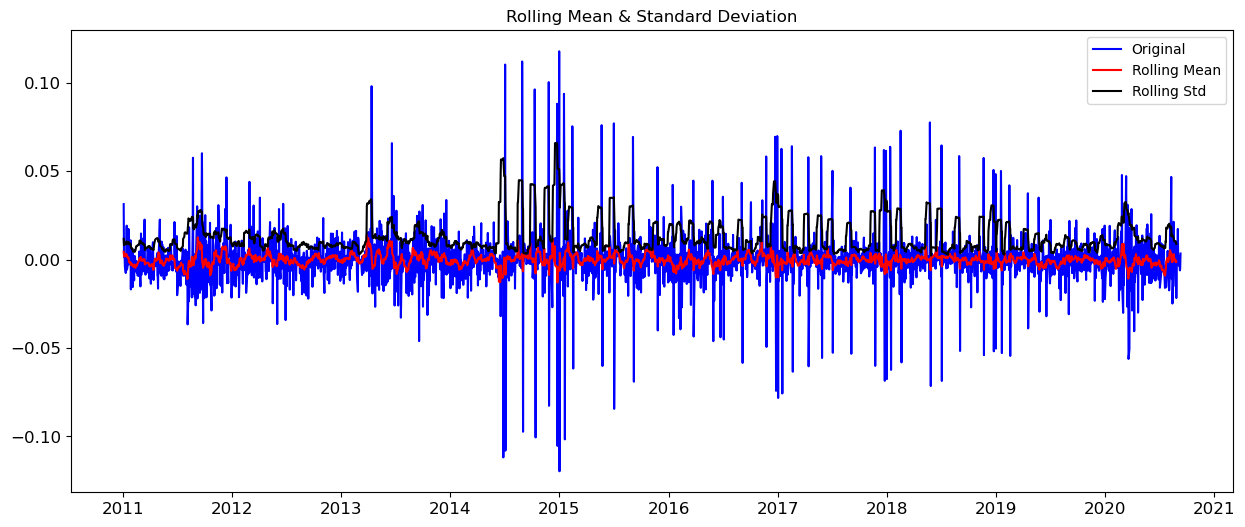

Results of Dickey-Fuller Test:
Test Statistic                  -24.003958
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    2524.000000
Critical Value (1%)              -3.432943
Critical Value (5%)              -2.862686
Critical Value (10%)             -2.567380
dtype: float64


In [60]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [61]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

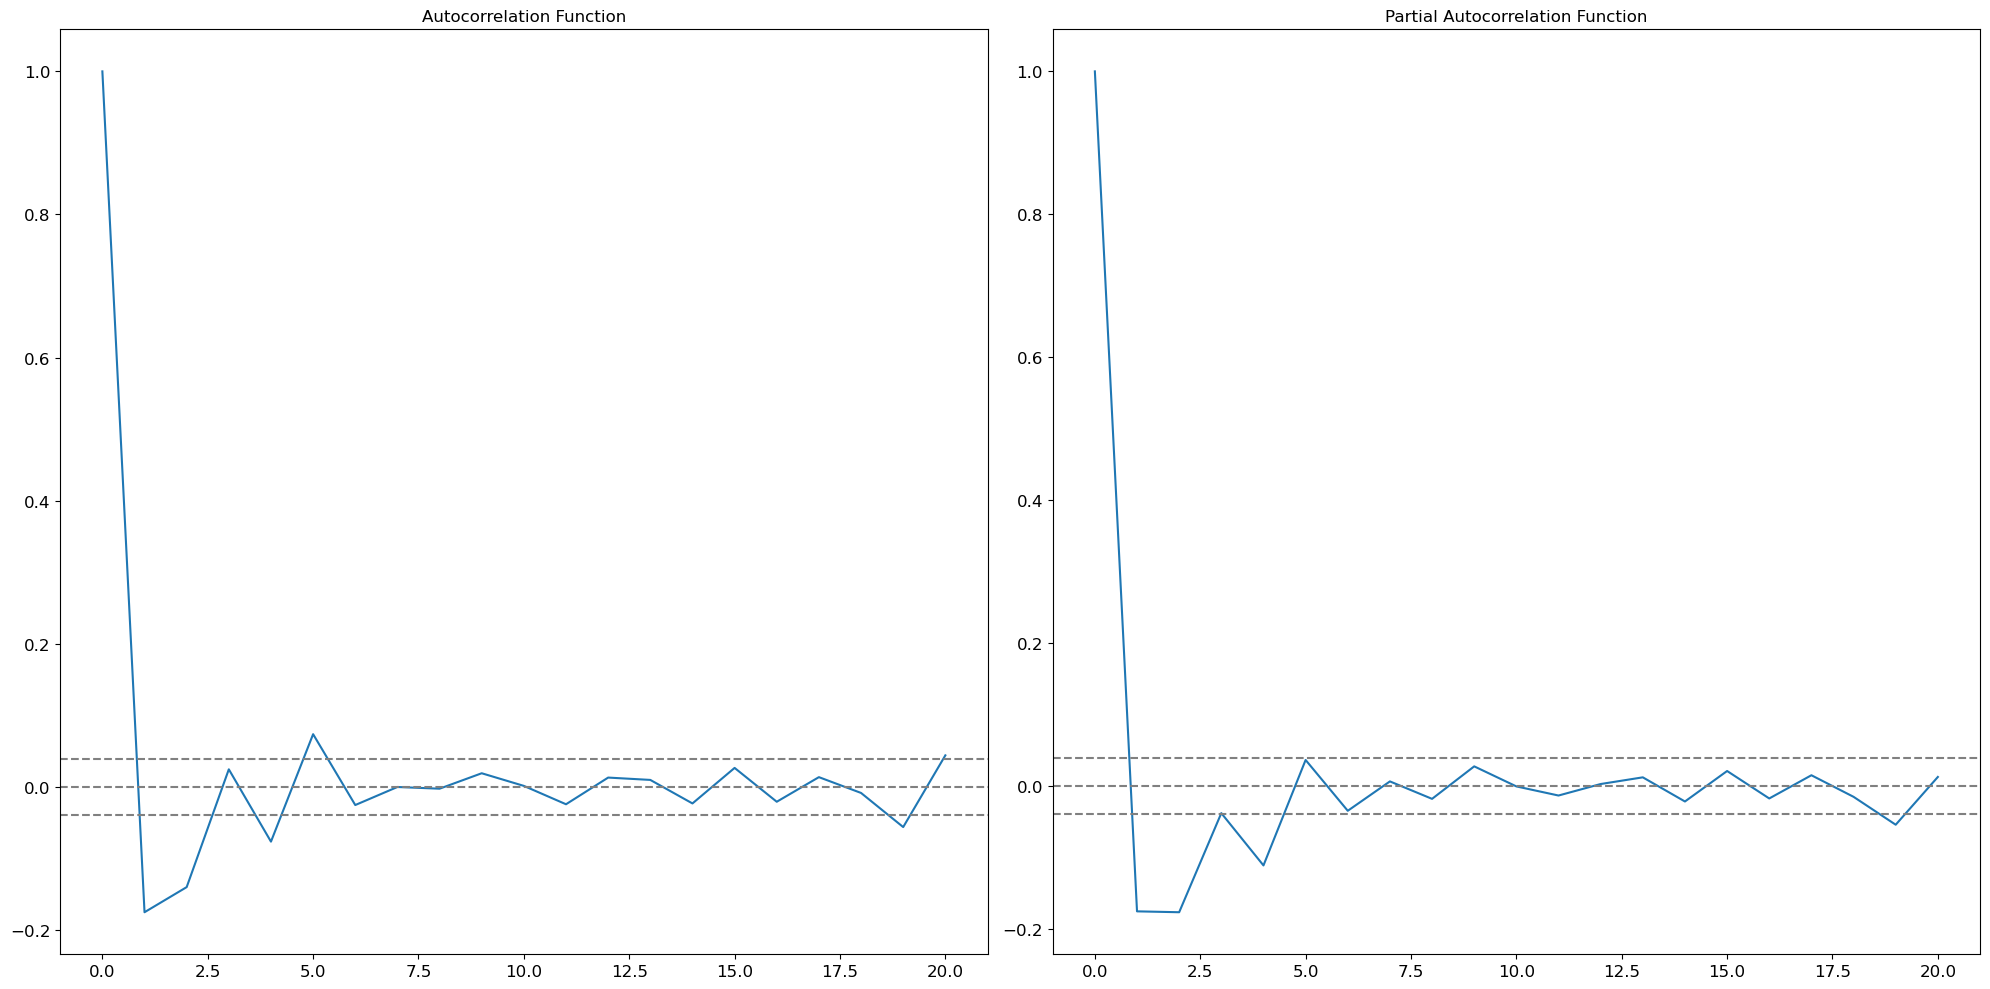

In [62]:
plt.figure(figsize=(20,10))

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packa

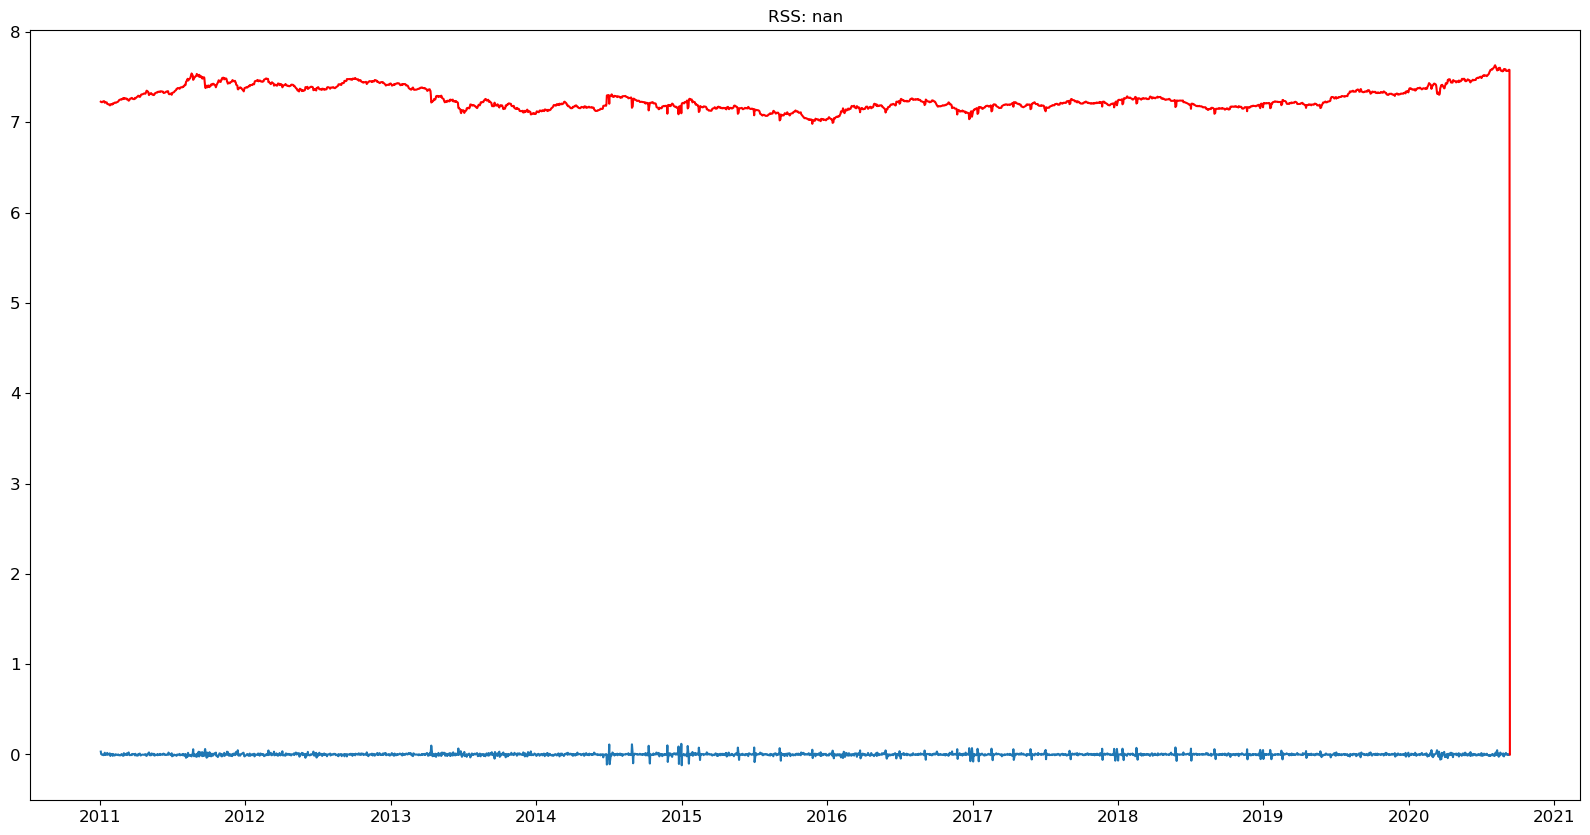

In [65]:
from statsmodels.tsa.arima.model import ARIMA

# AR model
model = ARIMA(ts_log, order=(1, 1, 0)) 
results_AR = model.fit() 
plt.figure(figsize=(20,10))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))
plt.show()

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packa

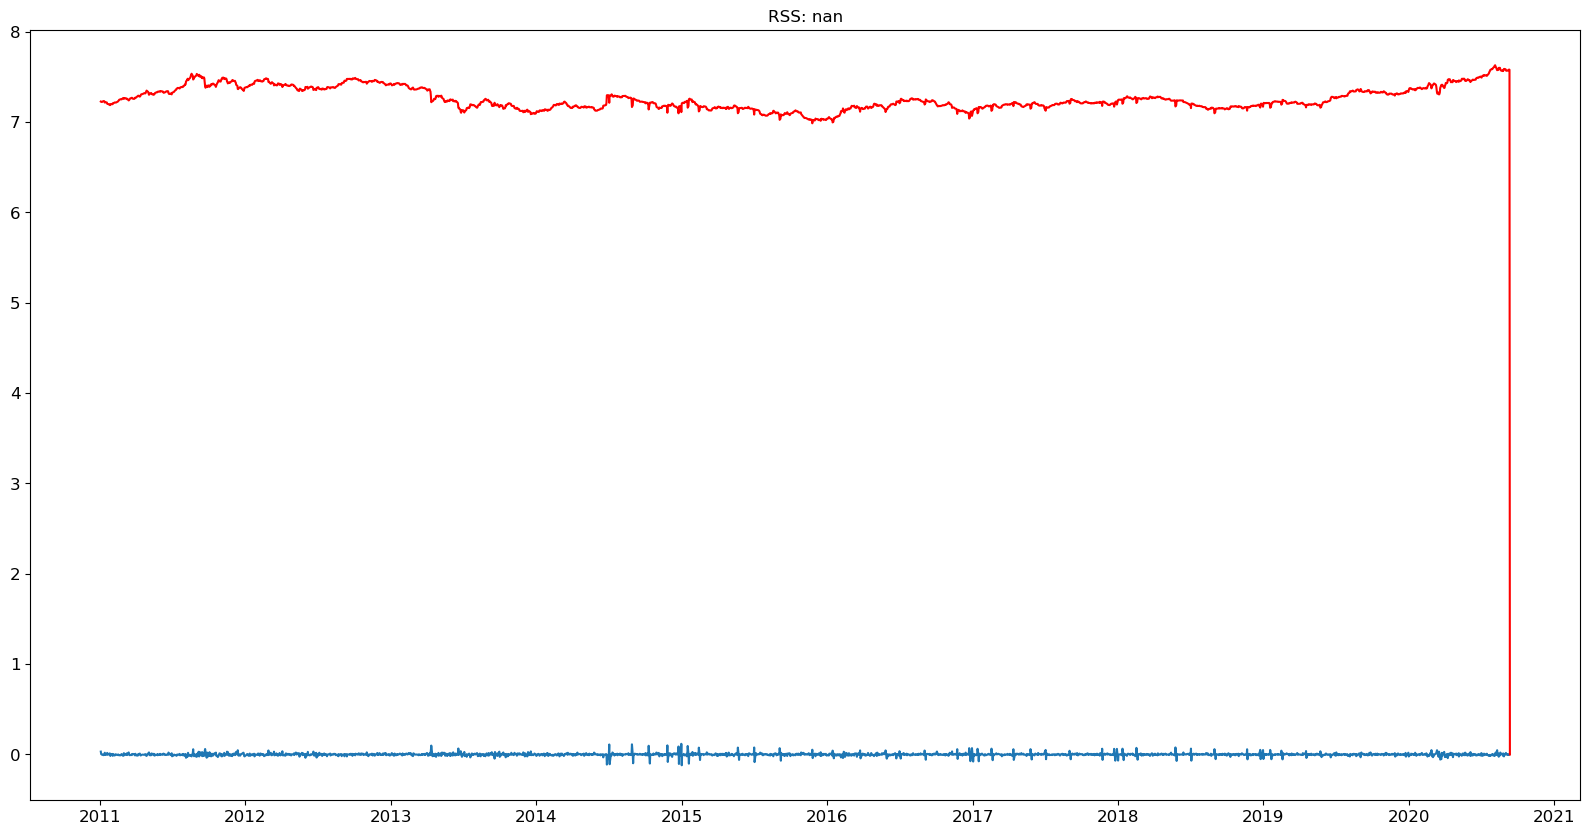

In [66]:
# MA Model

model = ARIMA(ts_log, order=(0, 1, 1))  
results_MA = model.fit()  
plt.figure(figsize=(20,10))
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
plt.show()

C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\USER\anaconda3\lib\site-packa

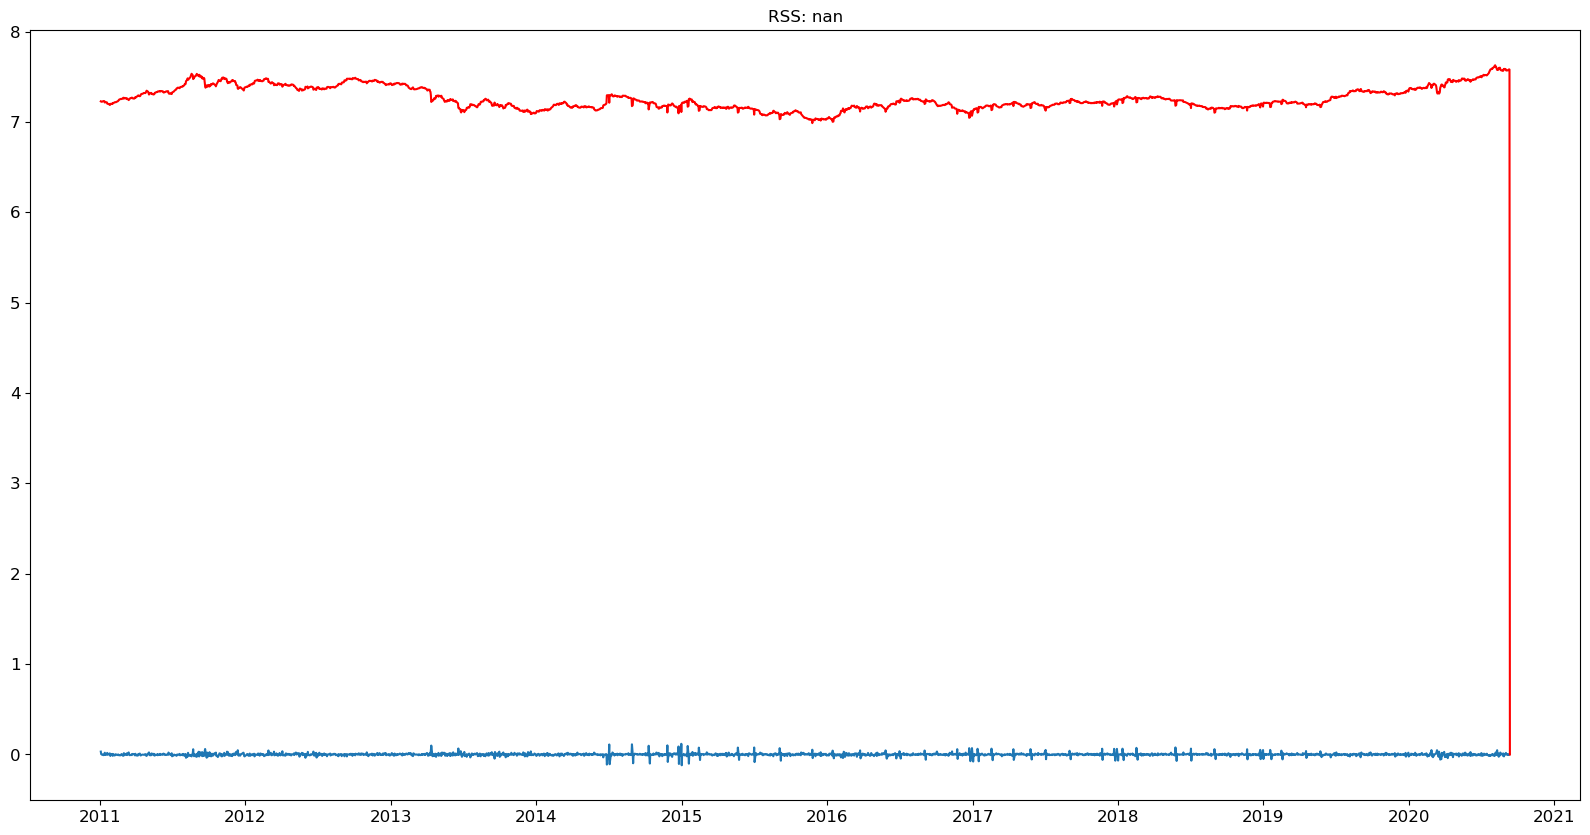

In [67]:
# combined mobel

model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit()  
plt.figure(figsize=(20,10))
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plt.show()

In [68]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Date
2020-09-11    0.000000
2020-09-10    7.579347
2020-09-09    7.582180
2020-09-08    7.578740
2020-09-07    7.573900
dtype: float64


In [69]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Date
2020-09-11     0.000000
2020-09-10     7.579347
2020-09-09    15.161527
2020-09-08    22.740267
2020-09-07    30.314166
dtype: float64


In [70]:
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
2020-09-11     7.579347
2020-09-10    15.158694
2020-09-09    22.740874
2020-09-08    30.319614
2020-09-07    37.893513
dtype: float64

In [71]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
predictions_ARIMA

Date
2020-09-11    1.957350e+03
2020-09-10    3.831219e+06
2020-09-09    7.520316e+09
2020-09-08    1.471096e+13
2020-09-07    2.863806e+16
                  ...     
2011-01-07             inf
2011-01-06             inf
2011-01-05             inf
2011-01-04             inf
2011-01-03             inf
Length: 2531, dtype: float64

## Saving the predictions

In [78]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor().fit(X_train,y_train)
preds1 = rf_model.predict(X_test)
rf_predictions = pd.DataFrame()
rf_predictions['Predicted Price'] = preds1


from xgboost import XGBRegressor

xgb_model = XGBRegressor().fit(X_train,y_train)
preds2 = xgb_model.predict(X_test)
xgb_predictions = pd.DataFrame()
xgb_predictions['Predicted Price'] = preds2